In [1]:

#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=5570820cbe5387729f290178c662bac1b1b0fa9dc2fada0f56f6b6da588832c6
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s

In [2]:

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

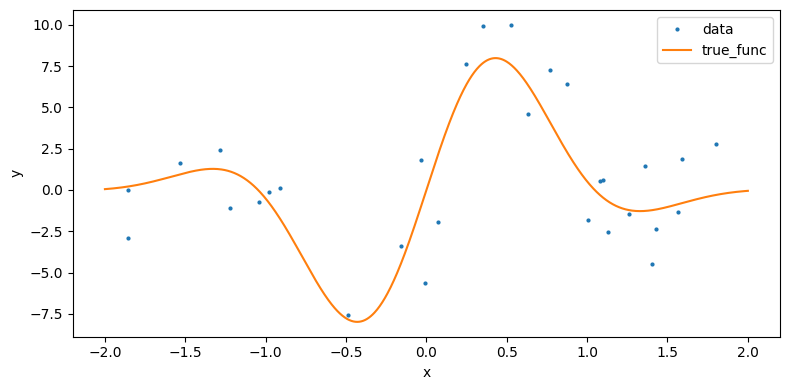

In [30]:

np.random.seed(20)

# データ数
N = 30

# 目的変数生成関数
def make_data(x, eps):
  y = 10*np.sin(3*x) * np.exp(-x**2)
  noise = np.random.normal(0, eps, size=x.shape[0])
  return y+ noise

# 説明変数をサンプリング
x_data = np.random.uniform(low=-2., high=2., size=N)
# 目的変数生成
y_data =  make_data(x_data, 2.0)
# 関数可視化用説明変数
x_linspace = np.linspace(-2., 2., 1000)
# 関数可視化用目的変数
y_linspace = make_data(x_linspace, 0.0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_data, y_data, 'o', markersize=2, label='data');
ax.plot(x_linspace, y_linspace, label='true_func')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.tight_layout();

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, DenseNN
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

## Model setting

In [31]:
# dim of hidden layer
h1,h2 = 10,10

class Model(PyroModule):
  #define each component
  def __init__(self,h1=h1,h2=h2):
    super().__init__()
    #first layer
    self.fc1 = PyroModule[nn.Linear](1,h1)
    self.fc1.weight = PyroSample(dist.Normal(0,10).expand([h1,1]).to_event(2))
    self.fc1.bias = PyroSample(dist.Normal(0,10).expand([h1]).to_event(1))
    #2nd layer
    self.fc2 = PyroModule[nn.Linear](h1,h2)
    self.fc2.weight = PyroSample(dist.Normal(0,10).expand([h2,h1]).to_event(2))
    self.fc2.bias = PyroSample(dist.Normal(0,10).expand([h2]).to_event(1))
    #output
    self.fc3 = PyroModule[nn.Linear](h2,1)
    self.fc3.weight = PyroSample(dist.Normal(0,10).expand([1,h2]).to_event(2))
    self.fc3.bias = PyroSample(dist.Normal(0,10).expand([1]).to_event(1))
    #activate function
    self.relu = nn.ReLU()

  def forward(self,X,Y=None,h1=h1,h2=h2):
    X = self.relu(self.fc1(X))
    X = self.relu(self.fc2(X))
    mu = self.fc3(X)
    #samples observation noise
    sigma = pyro.sample("sigma",dist.Uniform(0,2))
    #indicate batch_shape is equal to num of data
    with pyro.plate("data",X.shape[0]):
      #shape =(N,1) -> 1 is interpreted as event_shape
      obs = pyro.sample("Y",dist.Normal(mu,sigma).to_event(1),obs=Y)
    return mu

#make instance of model
model = Model(h1=h1,h2=h2)

## Train

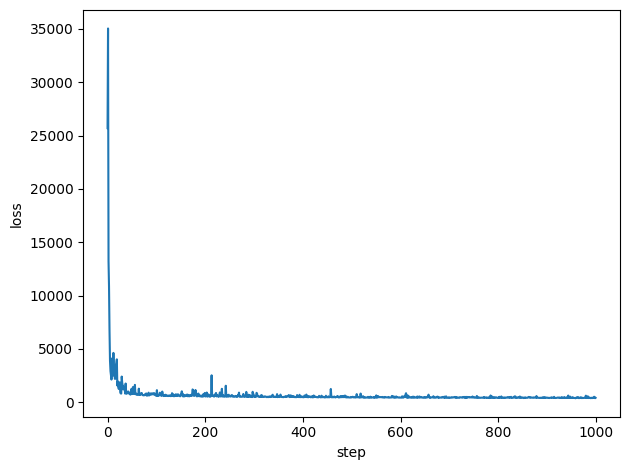

In [32]:
#init parameters
pyro.clear_param_store()
#set approximate function
guide = AutoDiagonalNormal(model)
#optimization algorithm
adam = pyro.optim.Adam({"lr":0.03})
#instance of SVI class
svi = SVI(model,guide,adam,loss=Trace_ELBO()) #model, approximate func, optimizer, loss

#convert data into tensor
x_data = torch.from_numpy(x_data).float().unsqueeze(-1)
y_data = torch.from_numpy(y_data).float().unsqueeze(-1)

#optimization
n_epoch = 1000
loss_list = []
for epoch in range(n_epoch):
  #variational inference
  loss = svi.step(x_data,y_data,h1,h2)
  loss_list.append(loss)

#plot loss
plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()

## Prediction

torch.Size([1000, 1])
torch.Size([500, 1000, 1])


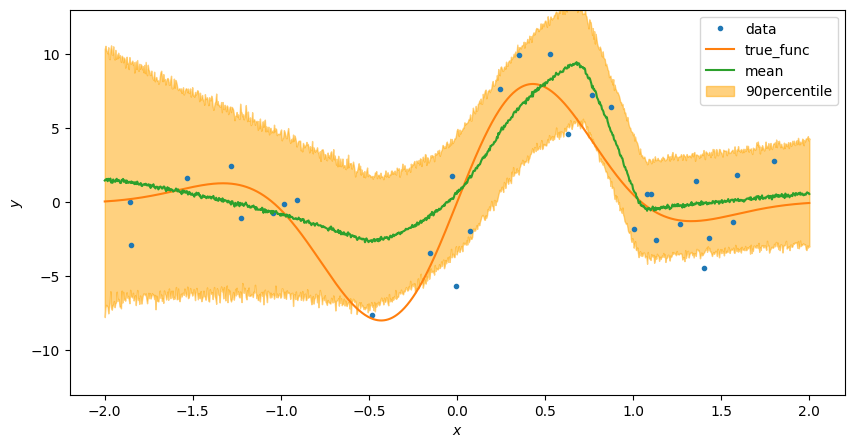

In [33]:
#make predictive model
predictive = Predictive(model,guide=guide,num_samples=500)
#new data
x_new = torch.linspace(-2,2,1000).unsqueeze(-1)
print(x_new.shape)
y_pred_samples = predictive(x_new,None,h1,h2)["Y"]
print(y_pred_samples.shape)
#90%tile
y_pred_mean = y_pred_samples.mean(axis=0)
percentiles = np.percentile(y_pred_samples.squeeze(-1),[5,95],axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
# データ可視化
ax.plot(x_data, y_data, 'o', markersize=3, label='data')
# 真の関数
ax.plot(x_linspace, y_linspace, label='true_func')
# 予測分布の平均
ax.plot(x_new, y_pred_mean, label='mean')
# 予測分布の90パーセンタイル
ax.fill_between(x_new.squeeze(-1), percentiles[0, :], percentiles[1, :],
                  alpha=0.5, label='90percentile', color='orange')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_ylim(-13 ,13)
ax.legend();